In [1]:
!pip install tensorflow==2.10.0

In [9]:
import tensorflow as tf

In [7]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from keras.layers import Flatten, Input, Dense, Dropout

In [8]:
sklearn.__version__

'1.2.2'

In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
!pip install transformers
from transformers import DistilBertTokenizer, TFDistilBertModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.3 MB/s eta 0:00:00


In [10]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
# Load dataset
df = pd.read_csv("Final_Dataset_without_Mendeley.csv")
df.fillna('', inplace=True)

In [12]:
def plot_train_val_loss_acc(history):
    # plot learning curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # plot validation curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [13]:
# Split data into train and test sets
X = df['text'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the input texts
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# Save tokenized data
with open('NEW_X_train_tokenized_DistilBERT_uncased.pkl', 'wb') as f:
  pickle.dump(X_train_tokenized, f)

with open('NEW_X_test_tokenized_DistilBERT_uncased.pkl', 'wb') as f:
  pickle.dump(X_test_tokenized, f)

#with open('NEW_X_train_tokenized_DistilBERT_uncased.pkl', 'rb') as f:
#    X_train_tokenized = pickle.load(f)

#with open('NEW_X_test_tokenized_DistilBERT_uncased.pkl', 'rb') as f:
#    X_test_tokenized = pickle.load(f)

In [14]:
# Load the pre-trained DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Unfreeze the DistilBERT layers
distilbert_model.trainable = True

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')

# Pass the input through the pre-trained DistilBERT model
sequence_output = distilbert_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
x = Dropout(0.2)(x)  # Add a dropout layer for regularization

output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Set different learning rates for DistilBERT layers and other layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [15]:
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=2, verbose=False, restore_best_weights=True)]
)

Epoch 1/10
1764/1764 [==============================] - 1577s 889ms/step - loss: 0.2005 - accuracy: 0.9084 - val_loss: 0.1159 - val_accuracy: 0.9519
Epoch 2/10
1764/1764 [==============================] - 1567s 888ms/step - loss: 0.0859 - accuracy: 0.9648 - val_loss: 0.1062 - val_accuracy: 0.9588
Epoch 3/10
1764/1764 [==============================] - 1567s 888ms/step - loss: 0.0455 - accuracy: 0.9817 - val_loss: 0.1170 - val_accuracy: 0.9601
Epoch 4/10
1764/1764 [==============================] - 1563s 886ms/step - loss: 0.0259 - accuracy: 0.9897 - val_loss: 0.1560 - val_accuracy: 0.9577
Epoch 5/10
1764/1764 [==============================] - 1558s 883ms/step - loss: 0.0189 - accuracy: 0.9924 - val_loss: 0.1385 - val_accuracy: 0.9597


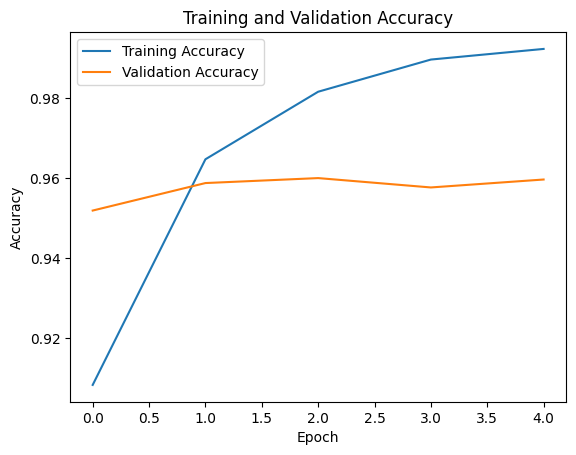

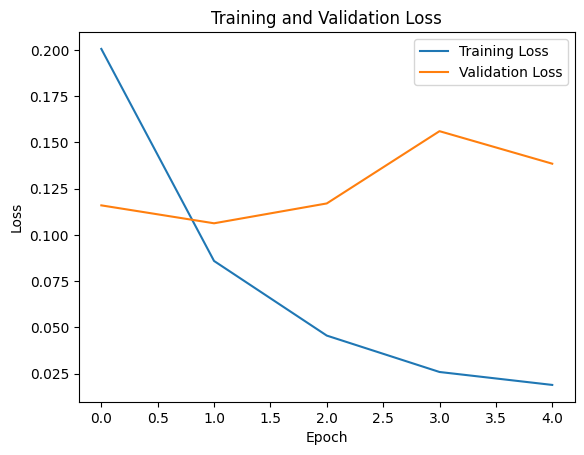

In [16]:
plot_train_val_loss_acc(history)

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=64)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

441/441 [==============================] - 120s 273ms/step - loss: 0.1170 - accuracy: 0.9601
Test loss: 0.117, Test accuracy: 0.960


882/882 [==============================] - 125s 140ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     14629
           1       0.96      0.96      0.96     13590

    accuracy                           0.96     28219
   macro avg       0.96      0.96      0.96     28219
weighted avg       0.96      0.96      0.96     28219



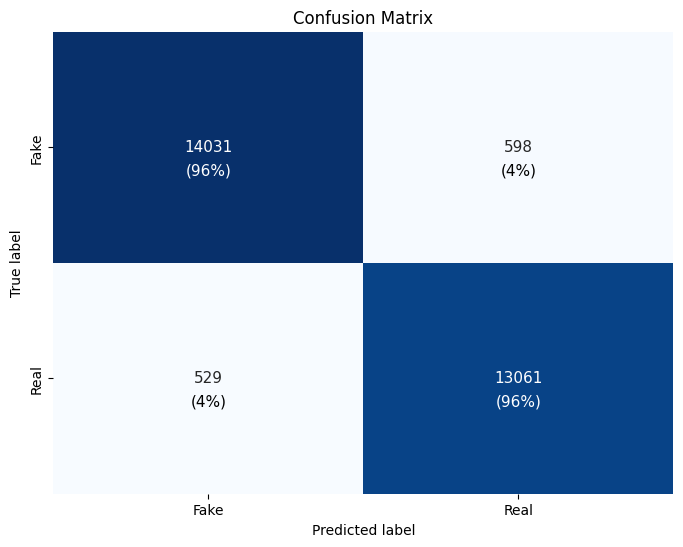

In [18]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

# Compute normalized values
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'], annot_kws={"fontsize": 11})

# Add normalized values below the actual values
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        text_color = 'black' if conf_mat_norm[i, j] < 0.5 else 'white'
        ax.text(j + 0.5, i + 0.6, f'({conf_mat_norm[i, j]:.0%})', ha='center', va='center', color=text_color, fontsize=11)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
model.save('NEW_dir_model_DistilBERT_96')

In [20]:
# Define the custom objects
custom_objects = {
    'TFDistilBertModel': TFDistilBertModel,
}

# Load the model with custom objects
model = load_model('NEW_dir_model_DistilBERT_96', custom_objects=custom_objects)

In [21]:
# Preprocess the text
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 128  # Max sequence length used during training
text = 'UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO] Now, most of the demonstrators gathered last night were exercising their constitutional and protected right to peaceful protest in order to raise issues and create change. Loretta Lynch aka Eric Holder in a skirt'
text_tokens = tokenizer.encode_plus(text, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf')

# Make the prediction
prediction = model.predict(text_tokens['input_ids'])[0][0]

# Convert prediction to a label
label = 1 if prediction >= 0.5 else 0
confidence = prediction if prediction >= 0.5 else 1 - prediction

print(f"Prediction: {label}")
print(f"Confidence: {confidence:.4f}")

1/1 [==============================] - 3s 3s/step
Prediction: 1
Confidence: 0.9999
